# Create cache files for the ME dataset

## Retrieve video_id and caption

In [1]:
import re
import os
import _pickle as cPickle
import numpy as np
import torch
from pytorch_transformers.tokenization_bert import BertTokenizer

In [2]:
cPickle.load(open('datasets/VQA/cache/VQA_minval_23_cleaned.pkl', 'rb'))[0]

{'question_id': 573843005,
 'image_id': 573843,
 'question': 'Are there clouds?',
 'answer': {'labels': tensor([ 425, 1403]),
  'scores': tensor([1.0000, 0.3000])},
 'q_token': tensor([ 101, 2024, 2045, 8044, 1029,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'q_input_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'q_segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [3]:
cPickle.load(open('datasets/VQA/cache/VQA_test_23_cleaned.pkl', 'rb'))[0]

{'image_id': 1,
 'question': 'What is the fence made of?',
 'question_id': 1000,
 'q_token': tensor([ 101, 2054, 2003, 1996, 8638, 2081, 1997, 1029,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'q_input_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'q_segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [4]:
max_length = 23
train_split = 'trainval'
val_split = 'minval'
test_split = 'test'
dataroot = 'datasets/ME'
train_cache_path = os.path.join(dataroot, 'cache', 'ME' + '_' + train_split + '_' + str(max_length) + '_' + 'cleaned' + '.pkl')
val_cache_path = os.path.join(dataroot, 'cache', 'ME' + '_' + val_split + '_' + str(max_length) + '_' + 'cleaned' + '.pkl')
test_cache_path = os.path.join(dataroot, 'cache', 'ME' + '_' + test_split + '_' + str(max_length) + '_' + 'cleaned' + '.pkl')

In [5]:
train_caption_path = '/aloui/MediaEval/dev-set/dev-set_video-captions.txt'
test_caption_path = '/aloui/MediaEval/test-set/test-set_video-captions.txt'


with open(train_caption_path, 'r') as f:
    lines = f.readlines()
train_entries = []
for line in lines:
    sample = {}
    vid_name, caption = line.split('\t')
    vid_id = re.findall(r'\d+', vid_name)[0]
    caption = caption.rstrip().replace('-', ' ')
    sample['video_id'] = int(vid_id)
    sample['caption'] = caption
    train_entries.append(sample)
    
with open(test_caption_path, 'r') as f:
    lines = f.readlines()
test_entries = []
for line in lines:
    sample = {}
    vid_name, caption = line.split('\t')
    vid_id = re.findall(r'\d+', vid_name)[0]
    caption = caption.rstrip().replace('-', ' ')
    sample['video_id'] = int(vid_id)
    sample['caption'] = caption
    test_entries.append(sample)

## Add scores

In [6]:
import pandas as pd

In [7]:
train_df = pd.read_csv('/aloui/MediaEval/dev-set/ground-truth/ground-truth_dev-set.csv')
train_df.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video10.webm,0.950,34,0.900,10
1,video100.webm,0.951,33,0.889,9
2,video10000.webm,0.832,33,1.000,13
3,video10001.webm,0.865,33,0.727,11
4,video10002.webm,0.899,59,0.792,24


In [8]:
score_dict = {}
for r in train_df.itertuples():
    vid_id = re.findall(r'\d+', r.video)[0]
    vid_id = int(vid_id)
    score_dict[vid_id] = [r._2, r._4]

In [9]:
for sample in train_entries:
    sample['scores'] = score_dict[sample['video_id']]

In [10]:
train_entries[0]

{'video_id': 10,
 'caption': 'couple relaxing on picnic crane shot',
 'scores': [0.95, 0.9]}

In [11]:
val_entries, train_entries = np.split(train_entries, [100])
val_entries, train_entries = list(val_entries), list(train_entries)

In [12]:
train_entries[0], len(train_entries), val_entries[0], len(val_entries), test_entries[0], len(test_entries)

({'video_id': 1106,
  'caption': 'african american girl using tablet pc at beach',
  'scores': [0.9229999999999999, 0.846]},
 7900,
 {'video_id': 10,
  'caption': 'couple relaxing on picnic crane shot',
  'scores': [0.95, 0.9]},
 100,
 {'video_id': 1, 'caption': 'snow and string lights'},
 2000)

## Add tokens

In [13]:
def assert_eq(real, expected):
    assert real == expected, "%s (true) vs %s (expected)" % (real, expected)

In [14]:
def tokenize(entries, tokenizer, max_length=16, padding_index=0):
    """Tokenizes the questions.

    This will add q_token in each entry of the dataset.
    -1 represent nil, and should be treated as padding_index in embedding
    """
    for entry in entries:
        tokens = tokenizer.encode(entry["caption"])
        tokens = tokens[: max_length - 2]
        tokens = tokenizer.add_special_tokens_single_sentence(tokens)

        segment_ids = [0] * len(tokens)
        input_mask = [1] * len(tokens)

        if len(tokens) < max_length:
            # Note here we pad in front of the sentence
            padding = [padding_index] * (max_length - len(tokens))
            tokens = tokens + padding
            input_mask += padding
            segment_ids += padding

        assert_eq(len(tokens), max_length)
        entry["c_token"] = tokens
        entry["c_input_mask"] = input_mask
        entry["c_segment_ids"] = segment_ids

In [15]:
bert_model = 'bert-base-uncased'
do_lower_case = True

tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)

In [16]:
tokenize(train_entries, tokenizer, max_length=max_length)

In [17]:
train_entries[0].keys()

dict_keys(['video_id', 'caption', 'scores', 'c_token', 'c_input_mask', 'c_segment_ids'])

## Tensorize

In [18]:
def tensorize(entries, split='trainval'):

    for entry in entries:
        caption = torch.from_numpy(np.array(entry["c_token"]))
        entry["c_token"] = caption

        c_input_mask = torch.from_numpy(np.array(entry["c_input_mask"]))
        entry["c_input_mask"] = c_input_mask

        c_segment_ids = torch.from_numpy(np.array(entry["c_segment_ids"]))
        entry["c_segment_ids"] = c_segment_ids

        if "test" not in split:
            # answer = entry["answer"]
            # labels = np.array(answer["labels"])
            scores = np.array(entry["scores"], dtype=np.float32)

            scores = torch.from_numpy(scores)
            entry["scores"] = scores
            # entry["answer"]["scores"] = scores

            '''if len(labels):
                labels = torch.from_numpy(labels)
                scores = torch.from_numpy(scores)
                entry["answer"]["labels"] = labels
                entry["answer"]["scores"] = scores
            else:
                entry["answer"]["labels"] = None
                entry["answer"]["scores"] = None'''

In [19]:
tensorize(train_entries, split='trainval')

In [20]:
train_entries[0]

{'video_id': 1106,
 'caption': 'african american girl using tablet pc at beach',
 'scores': tensor([0.9230, 0.8460]),
 'c_token': tensor([  101,  3060,  2137,  2611,  2478, 13855,  7473,  2012,  3509,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]),
 'c_input_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'c_segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [21]:
# this done only once to save entries to the disk
cPickle.dump(train_entries, open(train_cache_path, 'wb'))
cPickle.dump(val_entries, open(val_cache_path, 'wb'))
cPickle.dump(test_entries, open(test_cache_path, 'wb'))

# loading the dataset

In [4]:
from vilbert.datasets.me_dataset import MERegressionDataset
from pytorch_transformers.tokenization_bert import BertTokenizer
from vilbert.datasets._image_features_reader import ImageFeaturesH5Reader

In [9]:
bert_model = 'bert-base-uncased'
do_lower_case = True

tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)
image_features_reader = ImageFeaturesH5Reader("datasets/coco/features_100/COCO_test_resnext152_faster_rcnn_genome.lmdb", True)

08/03/2020 09:33:24 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/aloui/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [10]:
ds = MERegressionDataset(task="ME",
                         dataroot="datasets/ME/",
                         annotations_jsonpath="",
                         split="minval",
                         image_features_reader=image_features_reader,
                         gt_image_features_reader=None,
                         tokenizer=tokenizer,
                         bert_model=bert_model,
                         clean_datasets=True,
                         padding_index=0,
                         max_seq_length=23,
                         max_region_num=101,
                        )

08/03/2020 09:33:25 - INFO - vilbert.datasets.me_dataset -   Loading from datasets/ME/cache/ME_minval_23_cleaned.pkl


In [11]:
ds[0]

ValueError: b'10' is not in list

# explore the .lmdb features

In [8]:
# import caffe
import lmdb
import numpy as np
import matplotlib.pyplot as plt
# from caffe.proto import caffe_pb2

In [9]:
env = lmdb.open("datasets/coco/features_100/COCO_test_resnext152_faster_rcnn_genome.lmdb", max_readers=1, readonly=True, lock=False, readahead=False, meminit=False)

In [10]:
env.stat()

{'psize': 4096,
 'depth': 3,
 'branch_pages': 5,
 'leaf_pages': 879,
 'overflow_pages': 16368489,
 'entries': 81435}

In [11]:
data = np.load('output/1.npy', allow_pickle=True)

In [18]:
data.item()['objects'].shape

(99,)

In [19]:
data.item().get("features").shape

(100, 2048)

# Images

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [31]:
train_video_dir = '/aloui/MediaEval/dev-set/sources/'
test_video_dir = '/aloui/MediaEval/test-set/sources/'

train_image_dir = 'datasets/ME/images/train'
test_image_dir = 'datasets/ME/images/test'

In [ ]:
im_dict = dict()

for filename in os.listdir(train_video_dir):
    if filename.endswith(".webm"):
        vid_id = re.findall(r'\d+', filename)[0]
        vid_id = int(vid_id)
        video_path = os.path.join(train_video_dir, filename)
        cap = cv2.VideoCapture(video_path)
        i = 0
        frames = list()
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break
            frames.append(frame)
            i += 1
        cap.release()
        cv2.destroyAllWindows()
        center_frame = frames[i // 2]
        im_dict[vid_id] = center_frame
        # cv2.imwrite(str(vid_id)+'.jpg', center_frame)

In [ ]:
plt.imshow(im_dict.values()[0])

In [ ]:
im_dict = dict()

for k, filename in enumerate(os.listdir(test_video_dir)):
    if filename.endswith(".webm"):
        if not k % 10:
            print(k)
        vid_id = re.findall(r'\d+', filename)[0]
        vid_id = int(vid_id)
        video_path = os.path.join(test_video_dir, filename)
        cap = cv2.VideoCapture(video_path)
        i = 0
        frames = list()
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break
            frames.append(frame)
            i += 1
        center_frame = frames[i // 2]
        im_dict[vid_id] = center_frame
        # cv2.imwrite(str(vid_id)+'.jpg', center_frame)
cap.release()
cv2.destroyAllWindows()

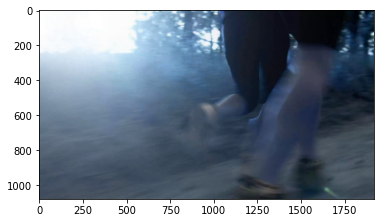

In [23]:
cap = cv2.VideoCapture('/aloui/MediaEval/dev-set/sources/video10.webm')
i = 0
frames = list()
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    frames.append(frame)
    # cv2.imwrite('kang'+str(i)+'.jpg',frame)
    i += 1
cap.release()
cv2.destroyAllWindows()

In [29]:
i // 2

84

Can't receive frame (stream end?). Exiting ...


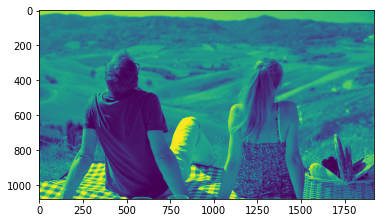

In [7]:
cap = cv2.VideoCapture('/aloui/MediaEval/dev-set/sources/video10.webm')
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [2]:
cap = cv2.VideoCapture('/aloui/MediaEval/dev-set/sources/video9999.webm')

In [3]:
ret, frame = cap.read()

In [4]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

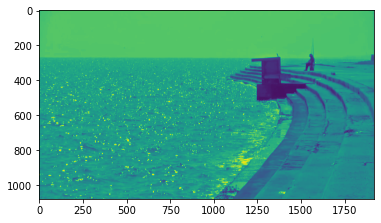

In [5]:
plt.imshow(gray)